In [ ]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time
import os

from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.utils import class_weight

#for deep learning
import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Activation, Masking, Dropout, SimpleRNN, Bidirectional
from keras.callbacks import History
from keras import callbacks
from tensorflow.keras.utils import to_categorical

In [ ]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time
import os
#os.chdir("C:/Data/aircraft/")

from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.utils import class_weight

#for deep learning
import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Activation, Masking, Dropout, LSTM, Bidirectional
from keras.callbacks import History
from keras import callbacks
from tensorflow.keras.utils import to_categorical

In [ ]:
parent_url = 'https://raw.githubusercontent.com/jingzhi93/Nasa-TurboFan-Predictive-Maintanence/master/CMAPSSData/'
'''
column_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = pd.read_csv(parent_url+'train_FD001.txt', sep = " ", header=None)
train_df.drop(columns=train_df.columns[[26,27]], inplace=True)
train_df.columns = column_names

test_df = pd.read_csv(parent_url+'test_FD001.txt', sep = " ", header=None)
test_df.drop(columns=test_df.columns[[26,27]], inplace=True)
test_df.columns = column_names

rul_df = pd.read_csv(parent_url+'RUL_FD001.txt', sep = " ", header=None)
rul_df.drop(columns=rul_df.columns[[1]], axis=1, inplace=True)
rul_df.columns = ['remaining_rul']

train_df.astype('float32')
'''

'\ncolumn_names = [\'id\', \'cycle\', \'setting1\', \'setting2\', \'setting3\', \'s1\', \'s2\', \'s3\',\n                     \'s4\', \'s5\', \'s6\', \'s7\', \'s8\', \'s9\', \'s10\', \'s11\', \'s12\', \'s13\', \'s14\',\n                     \'s15\', \'s16\', \'s17\', \'s18\', \'s19\', \'s20\', \'s21\']\n\ntrain_df = pd.read_csv(parent_url+\'train_FD001.txt\', sep = " ", header=None)\ntrain_df.drop(columns=train_df.columns[[26,27]], inplace=True)\ntrain_df.columns = column_names\n\ntest_df = pd.read_csv(parent_url+\'test_FD001.txt\', sep = " ", header=None)\ntest_df.drop(columns=test_df.columns[[26,27]], inplace=True)\ntest_df.columns = column_names\n\nrul_df = pd.read_csv(parent_url+\'RUL_FD001.txt\', sep = " ", header=None)\nrul_df.drop(columns=rul_df.columns[[1]], axis=1, inplace=True)\nrul_df.columns = [\'remaining_rul\']\n\ntrain_df.astype(\'float32\')\n'

In [ ]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10', 'SensorMeasure14',
     'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']

    df_train = pd.read_csv(parent_url+'train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)
    df_train['failure_lbl_1'] = [1 if i < 50 else 0 for i in df_train.RUL]
    df_train['failure_lbl_2'] = df_train['failure_lbl_1']
    df_train.failure_lbl_2[df_train.RUL < 25] = 2

    df_test = pd.read_csv(parent_url+'test_FD001.txt', delim_whitespace=True, names=input_file_column_names)
    
    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)

    y_true = pd.read_csv(parent_url+'RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index
    y_true['failure_lbl_1'] = [1 if i < 50 else 0 for i in y_true.RUL]
    y_true['failure_lbl_2'] = y_true['failure_lbl_1']
    y_true.failure_lbl_2[y_true.RUL < 25] = 2
    
    return df_train, df_test, y_true

In [ ]:
df_train, df_test, y_true = prepare_data(drop_cols=True)
df_train.shape, df_test.shape, y_true.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


((20631, 20), (13096, 17), (100, 4))

In [ ]:

feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL', 'failure_lbl_1', 'failure_lbl_2'])

In [ ]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [ ]:
df_train['failure'] = [1 if i < 50 else 0 for i in df_train.RUL]
y_true['failure'] = [1 if i < 50 else 0 for i in y_true.RUL]

In [ ]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,...,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21,RUL,failure_lbl_1,failure_lbl_2,failure
0,1,1,-0.080460,-0.666667,-0.632530,-0.186396,-0.380486,0.452496,-0.515152,-0.780490,...,0.266525,-0.588235,-0.272028,-0.333333,0.426357,0.449323,191,0,0,0
1,1,2,0.218391,-0.500000,-0.433735,-0.093961,-0.294733,0.256039,-0.575758,-0.799515,...,0.530917,-0.441176,-0.177376,-0.333333,0.333333,0.462027,190,0,0,0
2,1,3,-0.494253,0.500000,-0.313253,-0.260955,-0.258947,0.420290,-0.454545,-0.719914,...,0.590618,-0.558824,-0.285110,-0.666667,0.255814,0.242751,189,0,0,0
3,1,4,0.080460,0.000000,-0.313253,-0.487683,-0.337610,0.481481,-0.363636,-0.750965,...,0.778252,-0.411765,-0.666795,-0.333333,0.147287,0.324772,188,0,0,0
4,1,5,-0.218391,-0.333333,-0.301205,-0.485066,-0.190749,0.336554,-0.515152,-0.700081,...,0.492537,-0.529412,-0.195845,-0.166667,0.178295,0.409003,187,0,0,0


In [ ]:
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,0.090361,-0.378679,-0.461175,0.304348,-0.575758,-0.744773,-0.583333,0.292111,-0.558824,-0.382070,-0.333333,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-0.698795,-0.240898,-0.555368,0.610306,-0.666667,-0.706632,-0.226190,0.479744,-0.470588,-0.573682,-0.166667,0.364341,0.373654
2,1,3,0.034483,0.166667,-0.246988,-0.306736,-0.355503,0.371981,-0.545455,-0.683837,-0.226190,0.398721,-0.558824,-0.082724,-0.166667,0.457364,0.442695
3,1,4,0.482759,0.000000,-0.259036,-0.429693,-0.183997,0.359098,-0.606061,-0.788567,-0.488095,0.147122,-0.500000,-0.485956,-0.500000,0.333333,0.324220
4,1,5,0.160920,0.000000,-0.216867,-0.295836,-0.335922,0.388084,-0.666667,-0.795208,-0.452381,0.475480,-0.558824,-0.398230,-0.666667,0.317829,0.432753


In [ ]:
y_true.head()

,RUL,UnitNumber,failure_lbl_1,failure_lbl_2,failure
0,112,0,0,0,0
1,98,1,0,0,0
2,69,2,0,0,0
3,82,3,0,0,0
4,91,4,0,0,0


In [ ]:

def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [ ]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [ ]:

def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value
    
    id_df = df_mask.append(id_df,ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    start = num_elements-seq_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [ ]:
sequence_length = 50
mask_value = 0
label = "failure_lbl_1"

In [ ]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 15)


In [ ]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, label)) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [ ]:

#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 15)


In [ ]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

In [ ]:
nb_features = x_train.shape[2]
nb_out = 1

In [ ]:
nb_features

15

In [ ]:
class_0 = pd.Series(y_train).value_counts()[0]
class_1 = pd.Series(y_train).value_counts()[1]
total = class_0 + class_1

cls_wt = {0: class_1/total, 1: class_0/total}
cls_wt

{0: 0.3178437480134766, 1: 0.6821562519865234}

In [ ]:

def print_results(y_test, y_pred, multi_class = False):
    
    #f1-score
    if multi_class == True:
        f1 = f1_score(y_test, y_pred, average="macro")
    else:
        f1 = f1_score(y_test, y_pred)
    print(classification_report(y_test, y_pred))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t - 0.5)
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    #roc_auc_score
    if multi_class == False:
        model_roc_auc = roc_auc_score(y_test, y_pred) 
        print ("Area under curve : ",model_roc_auc,"\n")
        fpr,tpr,thresholds = roc_curve(y_test, y_pred)
        gmeans = np.sqrt(tpr * (1-fpr))
        ix = np.argmax(gmeans)
        threshold = np.round(thresholds[ix],3)

        plt.subplot(222)
        plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
      

In [ ]:
history = History()

model1 = Sequential()
model1.add(SimpleRNN(32, input_shape=(sequence_length, nb_features),
                    activation = 'relu'))
model1.add(Dense(8, activation = 'relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 32)                1536      
                                                                 
 dense_3 (Dense)             (None, 8)                 264       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,809
Trainable params: 1,809
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(len(x_train))

15731


In [ ]:
model1.fit(x_train, y_train, epochs=15, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
          callbacks = [history,
                       keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/15
222/222 [==============================] - 4s 15ms/step - loss: 0.0409 - accuracy: 0.9609 - val_loss: 0.1586 - val_accuracy: 0.9447
Epoch 2/15
222/222 [==============================] - 3s 14ms/step - loss: 0.0393 - accuracy: 0.9623 - val_loss: 0.1260 - val_accuracy: 0.9492
Epoch 3/15
222/222 [==============================] - 4s 16ms/step - loss: 0.0409 - accuracy: 0.9611 - val_loss: 0.1567 - val_accuracy: 0.9428
Epoch 4/15
222/222 [==============================] - 4s 18ms/step - loss: 0.0396 - accuracy: 0.9630 - val_loss: 0.1696 - val_accuracy: 0.9403
Epoch 5/15
222/222 [==============================] - 3s 15ms/step - loss: 0.0392 - accuracy: 0.9626 - val_loss: 0.1354 - val_accuracy: 0.9485
Epoch 6/15
222/222 [==============================] - 3s 15ms/step - loss: 0.0374 - accuracy: 0.9635 - val_loss: 0.1990 - val_accuracy: 0.9428
Epoch 7/15
222/222 [==============================] - 3s 15ms/step - loss: 0.0377 - accuracy: 0.9619 - val_loss: 0.1861 - val_accuracy: 0.9403

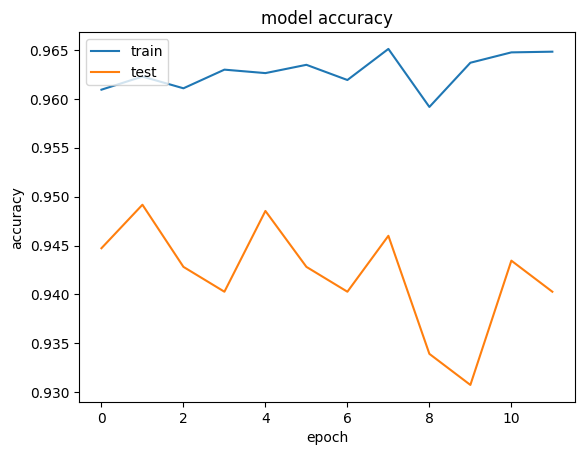

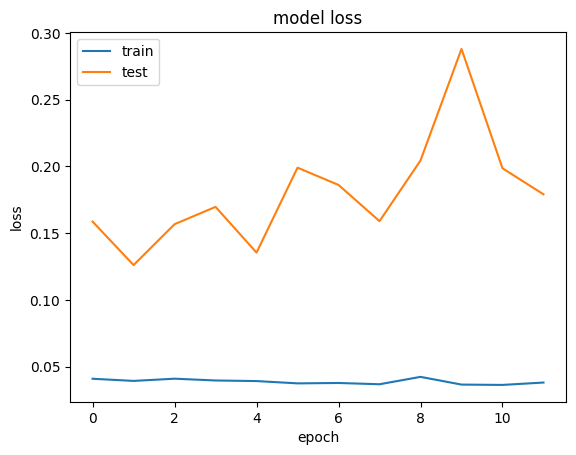

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred =  (model1.predict(x_test) > 0.5).astype("int32")

In [ ]:
print_results(y_true.failure, y_pred)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97        70
           1       0.91      0.97      0.94        30

    accuracy                           0.96       100
   macro avg       0.95      0.96      0.95       100
weighted avg       0.96      0.96      0.96       100

Area under curve :  0.9619047619047619 



In [ ]:
print(len(x_train))

In [ ]:
history = History()

model2 = Sequential()
model2.add(Bidirectional(SimpleRNN(32, input_shape=(sequence_length, nb_features),
                    activation = 'relu')))
model2.add(Dense(8, activation = 'relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
input_shape = x_train.shape  
model2.build(input_shape) 
model2.build(input_shape)
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (15731, 64)              3072      
 nal)                                                            
                                                                 
 dense_7 (Dense)             (15731, 8)                520       
                                                                 
 dense_8 (Dense)             (15731, 1)                9         
                                                                 
Total params: 3,601
Trainable params: 3,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.fit(x_train, y_train, epochs=15, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
          callbacks = [history,
                       keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/15
222/222 [==============================] - 7s 23ms/step - loss: 0.1161 - accuracy: 0.8998 - val_loss: 0.1452 - val_accuracy: 0.9358
Epoch 2/15
222/222 [==============================] - 5s 21ms/step - loss: 0.0614 - accuracy: 0.9427 - val_loss: 0.1277 - val_accuracy: 0.9428
Epoch 3/15
222/222 [==============================] - 5s 21ms/step - loss: 0.0524 - accuracy: 0.9498 - val_loss: 0.1550 - val_accuracy: 0.9333
Epoch 4/15
222/222 [==============================] - 5s 21ms/step - loss: 0.0494 - accuracy: 0.9526 - val_loss: 0.1412 - val_accuracy: 0.9352
Epoch 5/15
222/222 [==============================] - 5s 22ms/step - loss: 0.0452 - accuracy: 0.9564 - val_loss: 0.1837 - val_accuracy: 0.9193
Epoch 6/15
222/222 [==============================] - 5s 22ms/step - loss: 0.0413 - accuracy: 0.9604 - val_loss: 0.1400 - val_accuracy: 0.9346
Epoch 7/15
222/222 [==============================] - 5s 21ms/step - loss: 0.0390 - accuracy: 0.9636 - val_loss: 0.1648 - val_accuracy: 0.9327

In [ ]:
y_pred =  (model2.predict(x_test) > 0.5).astype("int32")
print_results(y_true.failure, y_pred)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        70
           1       0.91      1.00      0.95        30

    accuracy                           0.97       100
   macro avg       0.95      0.98      0.97       100
weighted avg       0.97      0.97      0.97       100

Area under curve :  0.9785714285714286 

